# Korea University - COSE474-2023F: DeepLearning Final Project
## 2020330003 CHANGHO CHOI
### Overleaf: https://www.overleaf.com/read/hbrjgrsvzmkk#223b3d
### Github: https://github.com/hoho4702/DeepLearning-Final-Project

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
FOLDERNAME = '딥러닝/Final_Project'
assert FOLDERNAME is not None, '[!]'

import sys
sys.path.append('/drive/MyDrive/{}'.format(FOLDERNAME))

%cd ./drive/MyDrive/$FOLDERNAME

[Errno 2] No such file or directory: './drive/MyDrive/딥러닝/Final_Project'
/content/drive/MyDrive/딥러닝/Final_Project


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [68]:
epsilons = [0, .05, .1, .15, .2, .3, .5]
alphas = [5/255, 10/255, 15/255, 25/255, 50/255]
iters = 25
targets = []
datas = []
labels = []
pretrained_model = "./lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [72]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=False)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [73]:
# Get 1000 data, label, target pairs
cnt = 0
for i, (data, label) in enumerate(test_loader):
    if cnt == 1000:
        break

    target = torch.randint(0, 10, (1, )).item()
    while target == label:
        target = torch.randint(0, 10, (1, )).item()

    data, label = data.to(device), label.to(device)
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != label.item():
        continue

    else:
        cnt += 1
        targets.append(target)
        datas.append(data)
        labels.append(label)

datas = torch.stack(datas)
labels = torch.stack(labels)
targets = torch.tensor(targets)

In [74]:
# FGSM attack code
def fgsm_attack(image, data_grad, epsilon):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# PGD attack code
def pgd_attack(origin, image, data_grad, epsilon, alpha):

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - alpha*sign_data_grad
    # Adding clipping to maintain [0,1] range

    perturbed_image = torch.clamp(perturbed_image, min=origin-epsilon, max=origin+epsilon)
    clip = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return clip

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [75]:
def fgsm_test( model, device, test_loader, epsilon, targets, datas, labels ):

    # Accuracy counter
    correct = 0
    attack_success = 0
    adv_examples = []
    num_ex = 0

    # Loop over all examples in test set
    for i in range(len(targets)):
        target = targets[i:i+1].to(device)
        data = datas[i]
        label = labels[i]
        data, label = data.to(device), label.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            print("Wrong Data")
            break

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denorm(data)
        perturbed_data = fgsm_attack(data_denorm, data_grad, epsilon)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item(): # Attack success
            attack_success += 1
            # Special case for saving 0 epsilon examples
            if num_ex < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                if len(adv_examples) > num_ex:
                  adv_examples[num_ex] = (init_pred.item(), final_pred.item(), adv_ex)
                else:
                  adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                num_ex+=1
        else: # Attack Fail
            if final_pred.item() == label.item():
                correct += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(len(targets))
    success_rate = attack_success/float(len(targets)) * 100
    print("===FGSM ATTACK RESULT===")
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(targets)} = {accuracy}")
    print(f"\t\tAttack Success Rate(%) = ({attack_success} / {len(targets)}) * 100 = {success_rate:.2f}\n")

    # Return the accuracy and an adversarial example
    return accuracy, success_rate, adv_examples

In [76]:
def pgd_test( model, device, test_loader, datas, labels, targets, epsilon, alpha, iters ):

    # Accuracy counter
    correct = 0
    attack_success = 0
    adv_examples = []
    num_ex = 0

    # Loop over all examples in test set
    for i in range(len(targets)):
        # Send the target, data, origin and label to the device
        target = targets[i:i+1].to(device)
        data = datas[i].to(device)
        origin = denorm(datas[i].to(device))
        label = labels[i].to(device)

        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            print("Wrong Data")
            break

        for _ in range(iters):
            loss = F.nll_loss(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            data_denorm = denorm(data)
            perturbed_data = pgd_attack(origin, data_denorm, data_grad, epsilon, alpha)

            data = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
            data = data.to(device).clone().detach().requires_grad_(True)
            output = model(data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item(): # Attack success
            attack_success += 1
            # Special case for saving 0 epsilon examples
            if num_ex < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                if len(adv_examples) > num_ex:
                  adv_examples[num_ex] = (init_pred.item(), final_pred.item(), adv_ex)
                else:
                  adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                num_ex+=1
        else: # Attack Fail
            if final_pred.item() == label.item():
                correct += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(len(targets))
    success_rate = attack_success/float(len(targets)) * 100
    print("===PGD ATTACK RESULT===")
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(targets)} = {accuracy}")
    print(f"Alpha: {alpha:.2f}\tAttack Success Rate(%) = ({attack_success} / {len(targets)}) * 100 = {success_rate:.2f}\n")

    # Return the accuracy and an adversarial example
    return accuracy, success_rate, adv_examples

In [77]:
fgsm_accs, fgsm_rates, fgsm_exs = [], [], []

# Run test for each epsilon
for epsilon in epsilons:
    acc, rate, ex = fgsm_test(model, device, test_loader, epsilon, targets, datas, labels)
    fgsm_accs.append(acc)
    fgsm_rates.append(rate)
    fgsm_exs.append(ex)

===FGSM ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
		Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===FGSM ATTACK RESULT===
Epsilon: 0.05	Test Accuracy = 981 / 1000 = 0.981
		Attack Success Rate(%) = (4 / 1000) * 100 = 0.40

===FGSM ATTACK RESULT===
Epsilon: 0.10	Test Accuracy = 936 / 1000 = 0.936
		Attack Success Rate(%) = (24 / 1000) * 100 = 2.40

===FGSM ATTACK RESULT===
Epsilon: 0.15	Test Accuracy = 826 / 1000 = 0.826
		Attack Success Rate(%) = (74 / 1000) * 100 = 7.40

===FGSM ATTACK RESULT===
Epsilon: 0.20	Test Accuracy = 601 / 1000 = 0.601
		Attack Success Rate(%) = (170 / 1000) * 100 = 17.00

===FGSM ATTACK RESULT===
Epsilon: 0.30	Test Accuracy = 157 / 1000 = 0.157
		Attack Success Rate(%) = (323 / 1000) * 100 = 32.30

===FGSM ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 61 / 1000 = 0.061
		Attack Success Rate(%) = (220 / 1000) * 100 = 22.00



In [59]:
pgd_alphas, pgd_accs, pgd_rates, pgd_exs = [], [], [], []
pgd_max_accs, pgd_max_rates = [], []

# Run test for each epsilon
for i, epsilon in enumerate(epsilons):
    alps, accs, rates, exs = [], [], [], []
    for alpha in alphas:
        acc, rate, ex = pgd_test(model, device, test_loader, datas, labels, targets, epsilon, alpha, iters)
        alps.append(alpha)
        accs.append(acc)
        rates.append(rate)
        exs.append(ex)
    pgd_alphas.append(alps)
    pgd_accs.append(accs)
    pgd_rates.append(rates)
    pgd_exs.append(exs)
    pgd_max_accs.append(max(accs))
    pgd_max_rates.append(max(rates))

===PGD ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
Alpha: 0.02	Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===PGD ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
Alpha: 0.04	Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===PGD ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
Alpha: 0.06	Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===PGD ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
Alpha: 0.10	Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===PGD ATTACK RESULT===
Epsilon: 0.00	Test Accuracy = 1000 / 1000 = 1.0
Alpha: 0.20	Attack Success Rate(%) = (0 / 1000) * 100 = 0.00

===PGD ATTACK RESULT===
Epsilon: 0.05	Test Accuracy = 986 / 1000 = 0.986
Alpha: 0.02	Attack Success Rate(%) = (8 / 1000) * 100 = 0.80

===PGD ATTACK RESULT===
Epsilon: 0.05	Test Accuracy = 984 / 1000 = 0.984
Alpha: 0.04	Attack Success Rate(%) = (7 / 1000) * 100 = 0.70

===PGD ATTACK RESULT===
Epsilon: 0.05	Test Accuracy = 981 / 

In [64]:
for i in range(1):
    epsilon = 0.5
    alps, accs, rates, exs = [], [], [], []
    for alpha in alphas:
        acc, rate, ex = pgd_test(model, device, test_loader, datas, labels, targets, epsilon, alpha, iters)
        alps.append(alpha)
        accs.append(acc)
        rates.append(rate)
        exs.append(ex)
    pgd_alphas.append(alps)
    pgd_accs.append(accs)
    pgd_rates.append(rates)
    pgd_exs.append(exs)
    pgd_max_accs.append(max(accs))
    pgd_max_rates.append(max(rates))

===PGD ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 3 / 1000 = 0.003
Alpha: 0.02	Attack Success Rate(%) = (997 / 1000) * 100 = 99.70

===PGD ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 0 / 1000 = 0.0
Alpha: 0.04	Attack Success Rate(%) = (1000 / 1000) * 100 = 100.00

===PGD ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 0 / 1000 = 0.0
Alpha: 0.06	Attack Success Rate(%) = (1000 / 1000) * 100 = 100.00

===PGD ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 0 / 1000 = 0.0
Alpha: 0.10	Attack Success Rate(%) = (1000 / 1000) * 100 = 100.00

===PGD ATTACK RESULT===
Epsilon: 0.50	Test Accuracy = 0 / 1000 = 0.0
Alpha: 0.20	Attack Success Rate(%) = (999 / 1000) * 100 = 99.90



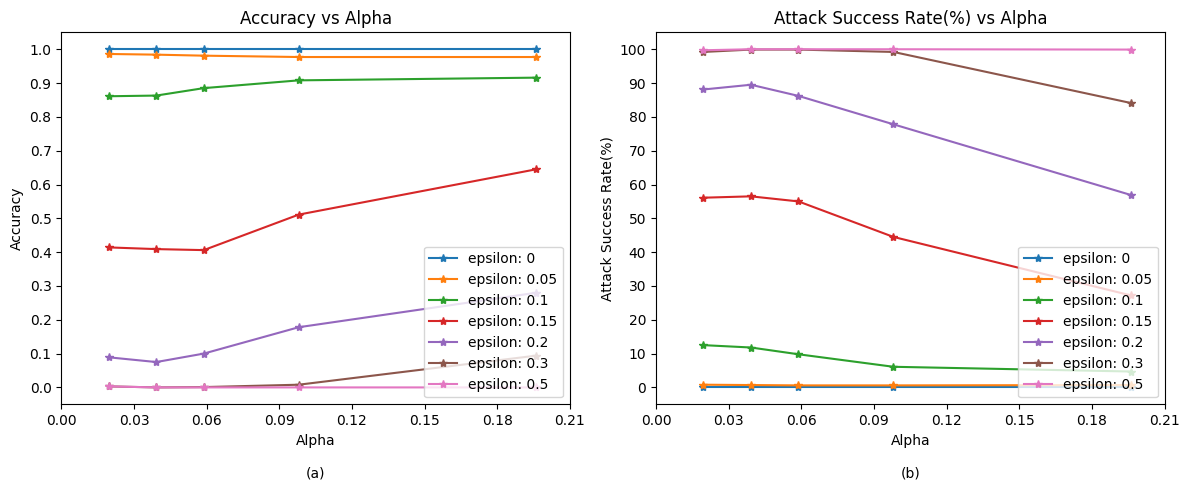

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
for i, epsilon in enumerate(epsilons):
  plt.plot(pgd_alphas[i], pgd_accs[i], "*-", label=f'epsilon: {epsilon}')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .22, step=0.03))
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha\n\n(a)")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i, epsilon in enumerate(epsilons):
  plt.plot(pgd_alphas[i], pgd_rates[i], "*-", label=f'epsilon: {epsilon}')
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, .22, step=0.03))
plt.title("Attack Success Rate(%) vs Alpha")
plt.xlabel("Alpha\n\n(b)")
plt.ylabel("Attack Success Rate(%)")
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

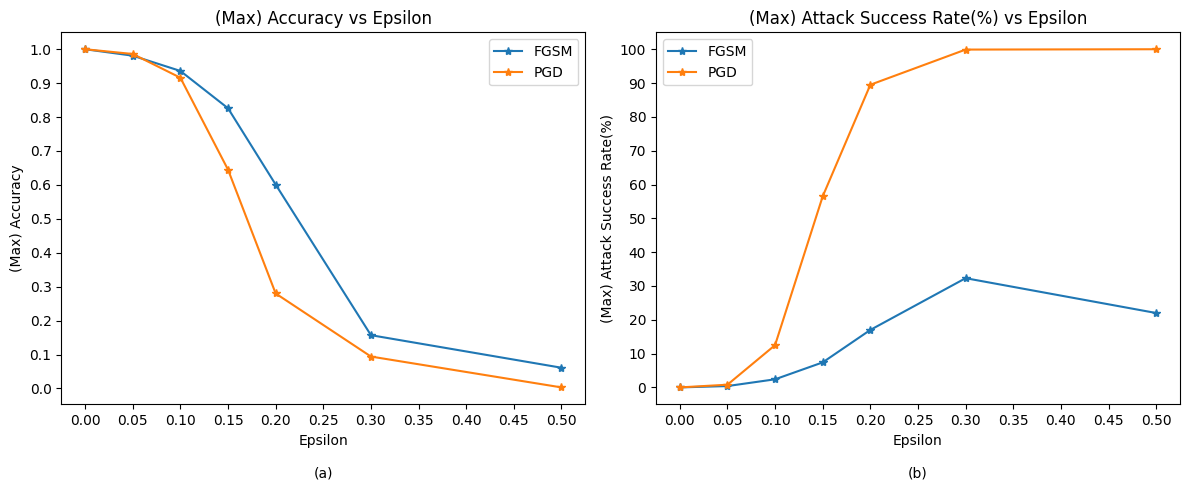

In [78]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epsilons, fgsm_accs, "*-", label='FGSM')
plt.plot(epsilons, pgd_max_accs, "*-", label='PGD')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("(Max) Accuracy vs Epsilon")
plt.xlabel("Epsilon\n\n(a)")
plt.ylabel("(Max) Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilons, fgsm_rates, "*-", label='FGSM')
plt.plot(epsilons, pgd_max_rates, "*-", label='PGD')
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("(Max) Attack Success Rate(%) vs Epsilon")
plt.xlabel("Epsilon\n\n(b)")
plt.ylabel("(Max) Attack Success Rate(%)")
plt.legend()

plt.tight_layout()
plt.show()

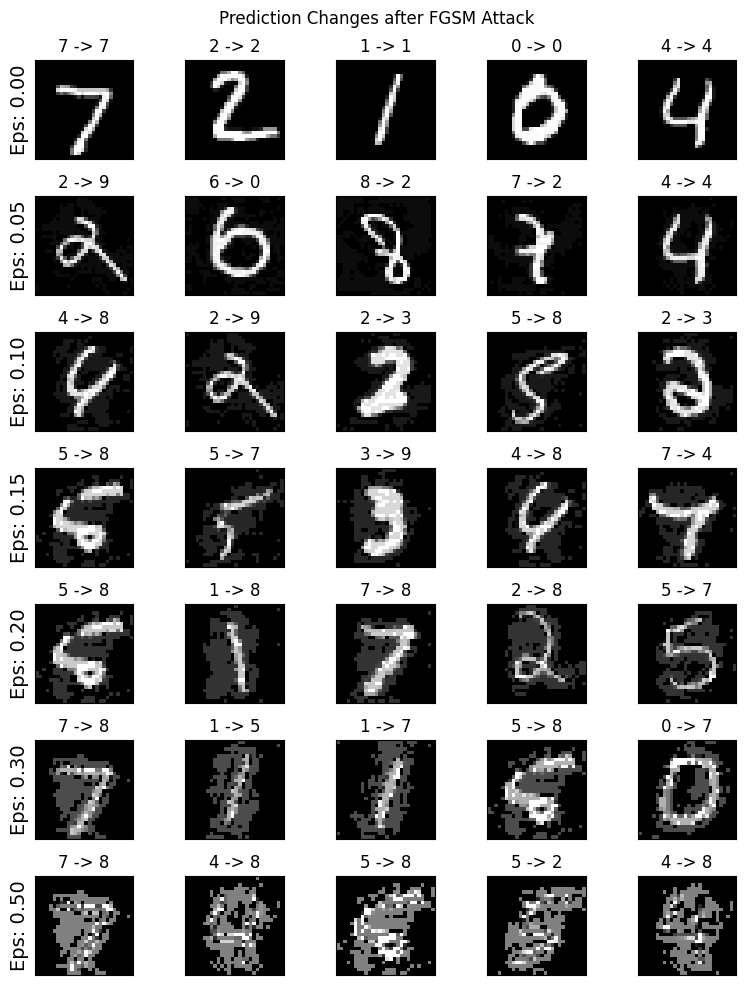

In [79]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(fgsm_exs[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(fgsm_exs[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]:.2f}", fontsize=14)
        orig,adv,ex = fgsm_exs[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.suptitle('Prediction Changes after FGSM Attack')
plt.tight_layout()
plt.show()

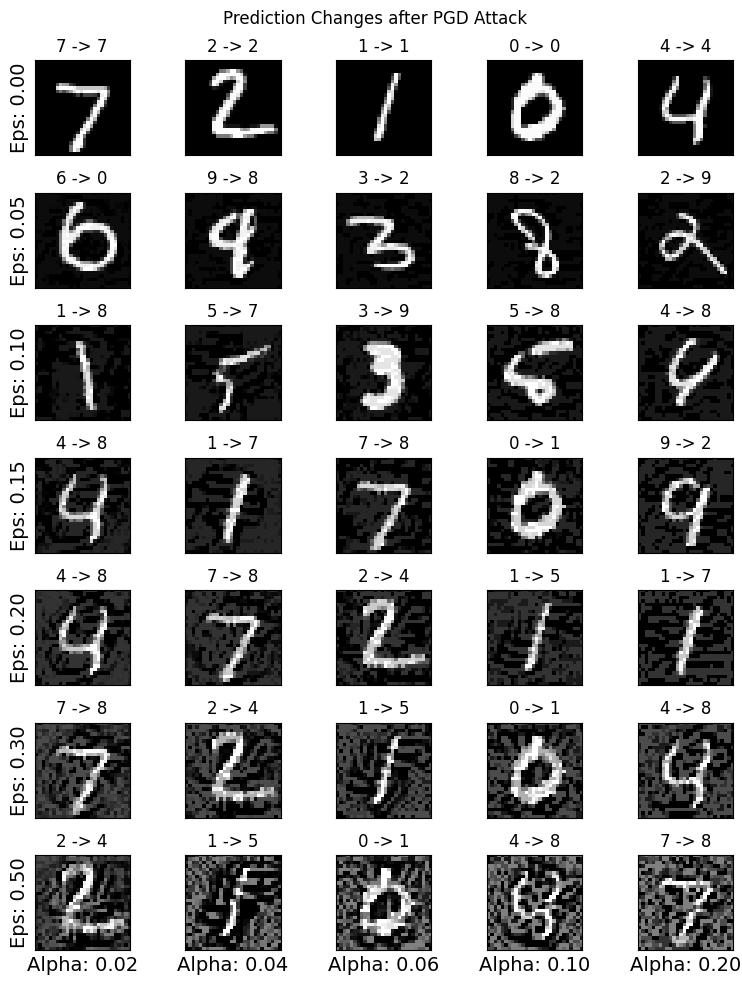

In [80]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i, epsilon in enumerate(epsilons):
  for j, alpha in enumerate(pgd_alphas[i]):
    cnt+=1
    plt.subplot(len(epsilons),len(alphas),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
      plt.ylabel(f"Eps: {epsilon:.2f}", fontsize=14)
    if i == len(epsilons) - 1:
      plt.xlabel(f"Alpha: {alpha:.2f}", fontsize=14)
    orig,adv,ex = pgd_exs[i][j][(i+j)%5]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.suptitle('Prediction Changes after PGD Attack')
plt.tight_layout()
plt.show()